# Installation

Pull `dataforest` and install

!(cd .. && git clone git@github.com:TheAustinator/dataforest.git)

In [2]:
pip install -e ../dataforest

Obtaining file:///home/ubuntu/code/dataforest
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: dataforest
    Found existing installation: dataforest 0.0.1
    Can't uninstall 'dataforest'. No files were found to uninstall.
  Running setup.py develop for dataforest
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -e .

Obtaining file:///home/ubuntu/code/cellforest
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: cellforest
    Found existing installation: cellforest 0.0.1
    Can't uninstall 'cellforest'. No files were found to uninstall.
  Running setup.py develop for cellforest
Note: you may need to restart the kernel to use updated packages.


In [53]:
# install tree (filesystem viewer used later)
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (88.7 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package tree.
(Reading database ... 32450 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...


In [1]:
%load_ext autoreload
%autoreload 2

import cellforest
from cellforest import Counts
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path

# Load Sample Data

In [2]:
cellranger_dir = Path("tests/data/v3_gz/sample_1")

In [3]:
from tests.utils.get_test_data import get_test_data
if not cellranger_dir.exists():
    get_test_data()
    if not cellrangder_dir.exists():
        raise ValueError("Notebook must be updated to conform to `get_test_data`")

In [4]:
ls {cellranger_dir}

barcodes.tsv.gz  features.tsv.gz  matrix.mtx.gz


# Quick Start

## Specify root of working directory tree

Use any directory, doesn't have to exist yet

In [5]:
example_dir = "tests/data/example_usage"

In [6]:
root_dir = f"{example_dir}/root"

# Counts Matrix

The counts matrix is a cells x genes matrix, built as a wrapper around `scipy.sparse.csr_matrix`. 

This data structure is central to the functionality of cellforest, so it's important to understand how it works. When using cellforest, you normally won't load/save it directly, but rather let cellforest handle that. However, if you don't need to automate workflows, and just want to do some counts matrix analysis outside of cellforest, you may want to instantiate it directly.

### Load from cellranger

`Counts` objects can be instantiated directly from cellranger outputs

In [7]:
rna = Counts.from_cellranger(cellranger_dir)

In [8]:
rna

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<300x150 sparse matrix of type '<class 'numpy.float64'>'
	with 1096 stored elements in Compressed Sparse Row format>

### Data attributes

The sparse matrix is stored in the `_matrix` attribute, which you generally shouldn't interact with directly. The `Counts` object has inherited most of the relevant methods of `csr_matrix`, so you can still do relevant calculations

In [9]:
rna.shape

(300, 150)

In [10]:
rna.sum()

1569.0

The genes and ensembl IDs are stored in `features`, and can also be accessed via `genes` and `ensgs`, respectively. These function as the column index for the matrix. Genes can also be accessed via `columns` (like pandas). Note that the enseml IDs will be stripped in any data downstream of a Seurat process, since Seurat lacks ensembl support.

In [11]:
rna.features.head()

,ensgs,genes
0,ENSG00000243485,MIR1302-10
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5
3,ENSG00000238009,RP11-34P13.7
4,ENSG00000239945,RP11-34P13.8


The 10X cell barcodes are stored in `cell_ids`, which can also be accessed via `index` (like pandas)

In [12]:
rna.cell_ids.head()

0    AAACATACAACCAC-1
1    AAACATTGAGCTAC-1
2    AAACATTGATCAGC-1
3    AAACCGTGCTTCCG-1
4    AAACCGTGTATGCG-1
Name: 0, dtype: object

### Slicing

The matrix can be sliced with integer indices, cell_ids, gene names, or ensembl IDs. The latter three can be presented in the form of strings, lists of strings, or `pandas.Series`. The matrix, features, and cell_ids will all be sliced correspondingly.

In [13]:
rna[:10, :20]

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<10x20 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [14]:
rna["AAACATACAACCAC-1"]

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<1x150 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [15]:
rna[["AAACATACAACCAC-1", "AAACATTGATCAGC-1"]]

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<2x150 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [16]:
rna[["AAACATACAACCAC-1", "AAACATTGATCAGC-1"], 1:10]

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<2x9 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [17]:
rna[:, ["MIR1302-10", "RP11-34P13.7"]]

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<300x2 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [18]:
rna[:, "ENSG00000238009"]

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<300x1 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [19]:
rna[rna.cell_ids[:20]]

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<20x150 sparse matrix of type '<class 'numpy.float64'>'
	with 71 stored elements in Compressed Sparse Row format>

### Plotting

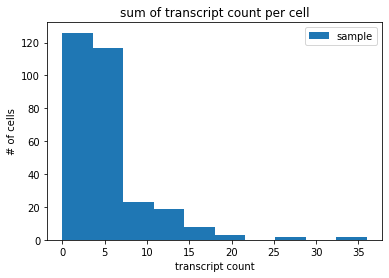

In [20]:
rna.hist();

Change aggregation function and axis, add labels, and forward kwargs to matplotlib

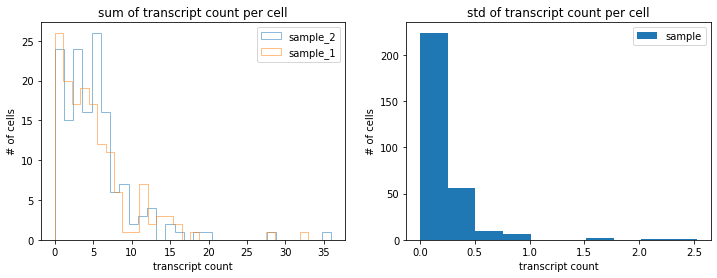

In [21]:
half_of_cells = rna._matrix.shape[0] // 2
labels = ["sample_1"] * half_of_cells + ["sample_2"] * half_of_cells  # mock cell labels for 2 samples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # figure with 1x2 axes
rna.hist("sum", axis=0, ax=ax1, labels=labels, bins=30, alpha=0.5, histtype='step')  # plot on 1st axes object
rna.hist("std", axis=0, ax=ax2);  # plot on 2nd axes object

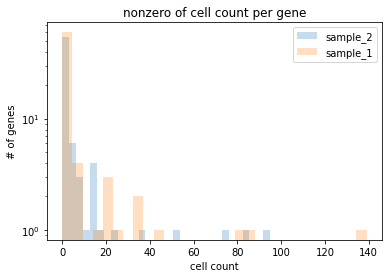

In [22]:
half_of_genes = rna.shape[1] // 2
dummy_labels = half_of_genes * ["sample_1"] + half_of_genes * ["sample_2"]
rna.hist(agg="nonzero", axis=1, labels=dummy_labels, alpha=0.25, bins=30, log=True);

Scatterplot

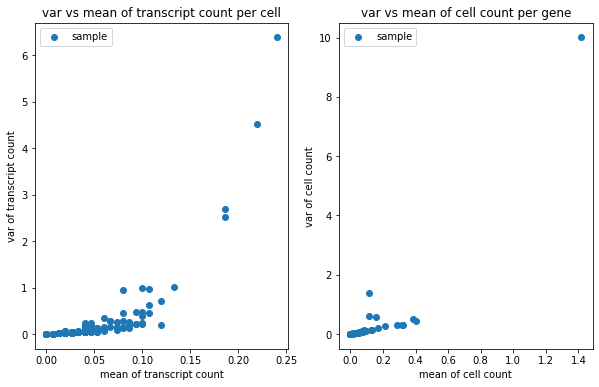

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))  # figure with 1x2 axes
rna.scatter("mean", "var", axis="cells", ax=ax1)  # plot on 1st axes object
rna.scatter("mean", "var", axis="genes", ax=ax2);  # plot on 2nd axes object

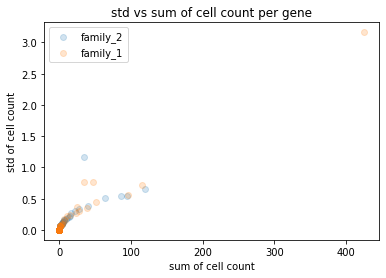

In [24]:
num_genes = rna._matrix.shape[1]
labels = ["family_1"] * (num_genes // 2) + ["family_2"] * (num_genes // 2)  # mock gene families for 2 samples
rna.scatter(agg_x="sum", agg_y="std", axis=1, labels=labels, alpha=0.2);  # plot std vs total cell count for each gene family

### Concatenation

A list of `Counts` objects can be `concatenate`ed, or one or more `Counts` objects can be appended to an existing one. Concatenation can occur along either the cells (`axis=0`) or genes (`axis=1`) dimensions, whereas `append` assumes the cells dimension. `hstack` and `vstack` can be used as alternatives to concatenation along the cells and genes axes, respectively (like numpy).

In [25]:
rna_2 = Counts.concatenate([rna[:20], rna[30:50]])
rna_2

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<40x150 sparse matrix of type '<class 'numpy.float64'>'
	with 144 stored elements in Compressed Sparse Row format>

In [26]:
Counts.concatenate([rna[:, :20], rna[:, 30:50]], axis=1)

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<300x40 sparse matrix of type '<class 'numpy.float64'>'
	with 200 stored elements in Compressed Sparse Row format>

In [27]:
rna_2.append(rna[60:100])

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<80x150 sparse matrix of type '<class 'numpy.float64'>'
	with 292 stored elements in Compressed Sparse Row format>

`append` is not an `inplace` operation

In [28]:
rna_2

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<40x150 sparse matrix of type '<class 'numpy.float64'>'
	with 144 stored elements in Compressed Sparse Row format>

### Drop

We can drop specified cells or genes. This doesn't occur `inplace`

In [29]:
# TODO: .drop not implemented

We can also drop cells or genes with no UMIs

In [30]:
rna.dropna()

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<288x63 sparse matrix of type '<class 'numpy.float64'>'
	with 1096 stored elements in Compressed Sparse Row format>

In [31]:
rna.dropna(axis=1)

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<300x63 sparse matrix of type '<class 'numpy.float64'>'
	with 1096 stored elements in Compressed Sparse Row format>

### I/O

**DataFrame (converts to dense)**

In [32]:
rna.to_df().head()

genes,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,WRAP73,TP73,RP5-1092A11.5,RP5-1092A11.2,TP73-AS1,CCDC27,SMIM1,LRRC47,RP1-286D6.5,CEP104
0,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Save**

In [33]:
example_counts_path = "tests/data/example/counts/rna.pickle"
rna.save(example_counts_path)

In [34]:
ls {example_counts_path}

tests/data/example/counts/rna.pickle


**Load**

In [35]:
Counts.load(example_counts_path)

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<300x150 sparse matrix of type '<class 'numpy.float64'>'
	with 1096 stored elements in Compressed Sparse Row format>

**Others**

There are also `to_cellranger`, `to_rds`, and `from_rds` I/O methods. Note that they may leave behind intermediate artifacts (e.g. pickle files).

# Cellforest Loading Data

We can load data from cellranger outputs. If there are multiple samples and metadata is available, option 3 should be used. The data is loaded and combined in a `Counts` matrix as an attribute of our `CellBranch` object. Python (.pickle) and Seurat (.rds) versions are saved in our `root_dir`. A `meta.tsv` file will also be created, which will include `cell_id`s (barcodes) as an index, and any additional sample metadata for each cell.

The `root_dir` will serve as the base for all of our downstream analysis. Once this directory has been populated, you can use option 4 to load from the .pickle file rather than re-processing the cellranger outputs.

### Option 1: from single cellranger output

In [36]:
branch = cellforest.from_input_dirs(root_dir, cellranger_dir)
branch

In [37]:
ls {root_dir}

_logs/  _plots/  meta.tsv  rna.pickle  rna.rds


In [38]:
pd.read_csv(f"{root_dir}/meta.tsv", sep="\t", index_col=0).head()

,0
0,AAACATACAACCAC-1
1,AAACATTGAGCTAC-1
2,AAACATTGATCAGC-1
3,AAACCGTGCTTCCG-1
4,AAACCGTGTATGCG-1


### Option 2: from multiple cellranger outputs

In [39]:
cellranger_dir_2 = "tests/data/v3_gz/sample_2"
branch = cellforest.from_input_dirs(root_dir, [cellranger_dir, cellranger_dir_2])

### Option 3 (PREFERRED): From metadata

This is preferred because this will allow you to include your metadata in analysis, and to incorporate assay modalities other than transcriptomics in the future

In [40]:
# load example metadata
meta = pd.read_csv("tests/data/sample_metadata.tsv", sep="\t")
meta.head()

,sample,path_rna
0,sample_1,/home/ubuntu/code/cellforest/tests/data/v3_gz/...
1,sample_2,/home/ubuntu/code/cellforest/tests/data/v3_gz/...


In [41]:
ls /Users/austinmckay/code/cellforest/tests/data/

ls: cannot access '/Users/austinmckay/code/cellforest/tests/data/': No such file or directory


In [42]:
branch = cellforest.from_sample_metadata(root_dir, meta)

### Option 4 (for every subsequent load): From existing root

In [43]:
branch = cellforest.load(root_dir)

# Cellforest Interface

## Metadata

In [44]:
branch.meta

,sample
0,
AAACATACAACCAC-1,sample_1
AAACATTGAGCTAC-1,sample_1
AAACATTGATCAGC-1,sample_1
AAACCGTGCTTCCG-1,sample_1
AAACCGTGTATGCG-1,sample_1
...,...
ATACCGGACTTCGC-1,sample_2
ATACCGGAGGTGTT-1,sample_2
ATACCGGATCTCGC-1,sample_2


## Counts

In [45]:
branch.rna

<class 'cellforest.structures.counts.Counts.Counts'>: [cell_ids x genes] matrix
<600x150 sparse matrix of type '<class 'numpy.float64'>'
	with 2104 stored elements in Compressed Sparse Row format>

Other useful methods include `copy`, 

## Workflow automation

The purpose of cellforest isn't just to interact with metadata and counts matrices -- we want to automate workflows and interact with the outputs. We do this with a specification, which we input as a dictionary, and gets converted to a `Spec` object internally. Each key represents a process name, and the values represent input parameters to that process.

In [46]:
spec = [
    {
        "_PROCESS_": "normalize",
        "_PARAMS_": {
            "min_genes": 5,
            "max_genes": 5000,
            "min_cells": 5,
            "nfeatures": 30,
            "perc_mito_cutoff": 20,
            "method": "seurat_default",
        },
        "_SUBSET_": {
            "sample": "sample_1"
        }
    } 
]

In [47]:
branch = cellforest.load(root_dir, branch_spec=spec)

In [48]:
ls {root_dir}

_logs/  _plots/  meta.tsv  rna.pickle  rna.rds


We can now execute processes from the spec

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


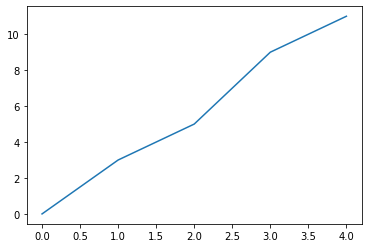

In [50]:
branch.process.normalize()

In [54]:
ls {root_dir}

_logs/  _plots/  meta.tsv  normalize/  rna.pickle  rna.rds


In [59]:
!tree {root_dir}

tests/data/example_usage/root
├── _logs
│   ├── pickle_to_rds.err
│   └── pickle_to_rds.out
├── _plots
│   └── test_plot.png
├── meta.tsv
├── normalize
│   ├── QwIdAYZT
│   │   ├── _logs
│   │   │   ├── normalize.err
│   │   │   ├── normalize.out
│   │   │   ├── rds_to_pickle.err
│   │   │   └── rds_to_pickle.out
│   │   ├── meta.tsv
│   │   ├── rna.pickle
│   │   ├── rna.rds
│   │   └── run_spec.yaml
│   └── run_catalogue.tsv
├── rna.pickle
└── rna.rds

5 directories, 15 files


The catalogue uses the `run_spec` to look up the `run_id` from the `run_catalogue` if one exists already, and stores one if not.

In [56]:
pd.read_csv(Path(root_dir) / "normalize/run_catalogue.tsv", sep="\t", index_col="run_spec")

,run_id
run_spec,
"{'_PARAMS_': {'max_genes': 5000, 'method': 'seurat_default', 'min_cells': 5, 'min_genes': 5, 'nfeatures': 30, 'perc_mito_cutoff': 20}, '_PROCESS_': 'normalize', '_SUBSET_': {'sample': 'sample_1'}}",QwIdAYZT


# Process

The default processes are defined in `cellforest.process`

In [57]:
from cellforest.processes import processes
process_path = str(Path(processes.__file__).parent)

In [61]:
!tree -L 2 {process_path}

/home/ubuntu/code/cellforest/cellforest/processes/processes
├── __init__.py
├── __pycache__
│   └── __init__.cpython-38.pyc
├── cluster
│   ├── __init__.py
│   ├── __pycache__
│   ├── cluster.R
│   └── process.py
├── expression
│   ├── __init__.py
│   ├── __pycache__
│   ├── diffexp.R
│   ├── markers.R
│   └── process.py
├── gsea
│   ├── __init__.py
│   ├── __pycache__
│   └── process.py
├── normalize
│   ├── __init__.py
│   ├── __pycache__
│   ├── process.py
│   ├── sctransform.R
│   └── seurat_default_normalize.R
├── reduce
│   ├── __init__.py
│   ├── __pycache__
│   ├── pca.R
│   ├── process.py
│   └── umap.py
└── test_process
    ├── __init__.py
    ├── __pycache__
    └── process.py

13 directories, 21 files


The `process.py` file contains the process function, which should be decorated with `dataprocess` (explained in Hooks section). `normalize/process.py` is pasted below.

The function will be broken up below

In [ ]:
from dataforest.hooks import dataprocess

from cellforest.utils.r.run_r_script import run_process_r_script


@dataprocess(requires="root", matrix_layer=True)
def normalize(forest: "CellBranch"):
    process_name = "normalize"
    input_metadata_path = forest.get_temp_meta_path(process_name)
    # TODO: add a root filepaths lookup
    input_rds_path = forest.root_dir / "rna.rds"
    output_rds_path = forest[process_name].path_map["rna_r"]
    min_genes = forest.spec[process_name]["min_genes"]
    max_genes = forest.spec[process_name]["max_genes"]
    min_cells = forest.spec[process_name]["min_cells"]
    perc_mito_cutoff = forest.spec[process_name]["perc_mito_cutoff"]
    r_functions_filepath = forest.schema.__class__.R_FILEPATHS["FUNCTIONS_FILE_PATH"]
    method = forest.spec[process_name]["method"]
    arg_list = [
        input_metadata_path,
        input_rds_path,
        output_rds_path,
        min_genes,
        max_genes,
        min_cells,
        perc_mito_cutoff,
        r_functions_filepath,
    ]
    if method == "sctransform":
        output_corrected_umi_path = forest[process_name].path_map["corrected_umi"]
        output_pearson_residual_path = forest[process_name].path_map["pearson_residual"]
        arg_list += [output_corrected_umi_path, output_pearson_residual_path]
        r_normalize_script = str(forest.schema.__class__.R_FILEPATHS["SCTRANSFORM_SCRIPT"])
    elif method == "seurat_default":
        verbose = True
        verbose = str(verbose).upper()
        nfeatures = forest.spec[process_name]["nfeatures"]
        arg_list += [verbose, nfeatures]
        r_normalize_script = str(forest.schema.__class__.R_FILEPATHS["SEURAT_DEFAULT_NORMALIZE_SCRIPT"])
    else:
        raise ValueError(f"Invalid normalization method: {method}. Use 'sctransform' or 'seurat_default'")
    run_process_r_script(forest, r_normalize_script, arg_list, process_name)


`forest` simply refers to the `CellBranch` object (`branch`) upon which we're executing this process
A hook function runs prior to the process start, which stores temporary metadata, which is removed afterward (more in hooks section). Here we're getting the path to that metadata

In [ ]:
def normalize(forest: "CellBranch"):
    process_name = "normalize"
    input_metadata_path = forest.get_temp_meta_path(process_name)

The second line below uses the `forest[process_name]` syntax, which refers to a `ProcessRun` object.

In [ ]:
    input_rds_path = forest.root_dir / "rna.rds"
    output_rds_path = forest[process_name].path_map["rna_r"]

In [ ]:
pr = branch["normalize"]
pr

The process run has a few attributes to navigate the file structure

File names

In [ ]:
pr.file_map

Path to output directory

In [ ]:
pr.path

Full paths.

In [ ]:
pr.path_map

There are two more attributes `files` and `filepaths`, which are just lists of the keys of `file_map` and `path_map`, respectively.

Check if the process has been run (just checks for logfiles in process run directory)

In [ ]:
pr.done

Check output files

In [ ]:
ls {str(pr.path)}

Check log files (`normalize.out` and `normalize.err`). They are intented to be stdout and stderr, but in reality, lines written in cellforest R code go to .out, and lines from other packages, e.g. Seurat, go to .err.

In [ ]:
pr.logs

Back to the process definition: these lines are simply extracting the parameters from the spec.

In [ ]:
    min_genes = forest.spec[process_name]["min_genes"]
    max_genes = forest.spec[process_name]["max_genes"]
    min_cells = forest.spec[process_name]["min_cells"]
    perc_mito_cutoff = forest.spec[process_name]["perc_mito_cutoff"]
    method = forest.spec[process_name]["method"]

We can check out the spec to see those values

In [ ]:
branch.spec

This line gets the filepath to some R utility functions from our configuration. It accesses the `__class__` attribute due to a metaprogramming implementation detail that allows us to dynamically change the configuration.

In [ ]:
    r_functions_filepath = forest.schema.__class__.R_FILEPATHS["FUNCTIONS_FILE_PATH"]

To inspect the configuration:

In [ ]:
# TODO: MAKE DATAHOOK - E.G. TO USE LATEST MATRIX, OR TO CONCAT CLUSTERS TO META

To update the configuration

Generally, you wouldn't want to dynamically update the configuration like this, but rather pass it in when you instantiate your `CellBranch`. 

What about having two of them with different configs? Test this -- if a problem, use a more global feeling interface to update it

The normalize process both filters out cells by mitochondrial fraction and does counts matrix normalization using either Seurat default normalization or sctransform, as specified in the parameters. It outputs 

### Data Specification

In addition to parameter specification, we may also want to specify the data which flows into each process. We can do that either by subsetting the data, to include only those which match the specification, or by filtering the data to exclude those which match the specification.

**Subset**

### Filter

### Partition

# Customizing modules